# Final Project
## Paper: Rant or rave: variation over time in the language of online reviews
#### Handed in by Gina-Maria Unger 01/843034

### Install Requirements

In [20]:
# Please uncomment to install packages

#!pip install pandas
#!pip install numpy
#!pip install json
#!pip install matplotlib
#!pip install math
#!pip install transformers
#!pip install torch
#!pip install tabulate
#!pip install scikit-learn
#!pip install statsmodels
#!pip install pymannkendall

### Import requirements

In [1]:
# Packages necessary to load/save the data
import pandas as pd
import json
import pickle

# Packages necessary to work of with data
from vader import SentimentIntensityAnalyzer
import numpy as np
import re
import math

# Packages necessary to work with BERT
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score, classification_report

# Packages necessary to create plots and tables (in latex-like style)
import matplotlib.pyplot as plt
from tabulate import tabulate

# Packages necessary to do statistical tests
import pymannkendall as mk
from statsmodels.stats.multitest import fdrcorrection

### IMDb Data of the Original Paper of Ziser et al (2023)

#### Load the IMDb Data

In [3]:
# Creating an empty dataframe and a list of paths indicating where the different parts of the IMDb data is stored
df_imdb = pd.DataFrame()
paths_json_imdb = ['IMDb/part-01.json', 'IMDb/part-02.json', 'IMDb/part-03.json', 'IMDb/part-04.json', 'IMDb/part-05.json', 'IMDb/part-06.json']

# For each path in the list indicating a json file that stores the data create a respective dataframe and concatenate it with the already loaded data so that in the end one dataframe stores all data
for path_json_imdb in paths_json_imdb:
    df_imdb_part = pd.read_json(path_json_imdb)
    df_imdb = pd.concat([df_imdb, df_imdb_part], ignore_index=True, sort=False)

#### Data Reduction

In [4]:
# Viewing the dataframe structure
df_imdb.head()

,review_id,reviewer,movie,rating,review_summary,review_date,spoiler_tag,review_detail,helpful
0,rw5704482,raeldor-96879,After Life (2019– ),9.0,Very Strong Season 2,3 May 2020,0,"I enjoyed the first season, but I must say I t...","[1, 1]"
1,rw5704483,dosleeb,The Valhalla Murders (2019– ),6.0,Icelandic detectives?,3 May 2020,0,I know Iceland is a small country and police d...,"[2, 2]"
2,rw5704484,brightconscious,Special OPS (2020– ),7.0,Nothing special,3 May 2020,0,"Except K K , no other actor looks comfortable ...","[0, 0]"
3,rw5704485,gasconyway,#BlackAF (2020– ),8.0,Good but,3 May 2020,0,I'm guessing that as a 62 year old white woman...,"[5, 9]"
4,rw5704487,mmason-15867,The Droving (2020),2.0,An honest review,3 May 2020,0,Here's the truth. There's not much to this mov...,"[26, 41]"


In [5]:
# Getting general information about the created dataframe like column types etc.
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 5571499 entries, 0 to 5571498

Data columns (total 9 columns):

 #   Column          Dtype  

---  ------          -----  

 0   review_id       object 

 1   reviewer        object 

 2   movie           object 

 3   rating          float64

 4   review_summary  object 

 5   review_date     object 

 6   spoiler_tag     int64  

 7   review_detail   object 

 8   helpful         object 

dtypes: float64(1), int64(1), object(7)

memory usage: 382.6+ MB


In [6]:
# Reducing the dataframe to specific columns, converting the column storing the review publishing date to datetime format, and inserting a new 'year' column that gives the year the review was created
df_imdb = df_imdb[['review_id', 'reviewer', 'rating', 'review_date', 'review_detail']]
df_imdb['review_date'] = pd.to_datetime(df_imdb['review_date'])
df_imdb.insert(4, 'year', df_imdb['review_date'].dt.year)

# Renaming columns for clarity
df_imdb.rename(columns={'review_date': 'date', 'review_detail': 'review'}, inplace=True)

# Filtering the data to include only rows with rating values of 1.0 or 10.0, means to reviews with positive and negative sentiment
df_imdb = df_imdb.loc[(df_imdb['rating'] == 1.0) | (df_imdb['rating'] == 10.0), ]

In [7]:
# Data seems to incorporate values for 2021 and before 2000 what is not in line with Ziser et al's (2023) IMDb data, hence these years will be excluded fo the matter of reproduction
print(sorted(df_imdb['year'].unique()))
df_imdb = df_imdb.loc[(df_imdb['year'] < 2021) & (df_imdb['year'] > 1999), ]
print(sorted(df_imdb['year'].unique()))

[1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


In [8]:
# Viewing count frequency of reviews per year and sentiment before applying and sampling procedure
print(df_imdb.groupby(['year', 'rating']).size())

year  rating

2000  1.0         5252

      10.0       20734

2001  1.0         7071

      10.0       26649

2002  1.0         8769

      10.0       31067

2003  1.0         8785

      10.0       29519

2004  1.0         8635

      10.0       28578

2005  1.0        16906

      10.0       50591

2006  1.0        21533

      10.0       64874

2007  1.0        16336

      10.0       41210

2008  1.0        14901

      10.0       31690

2009  1.0        12652

      10.0       26051

2010  1.0        11954

      10.0       24511

2011  1.0        10757

      10.0       23041

2012  1.0        13157

      10.0       28080

2013  1.0        14164

      10.0       29608

2014  1.0        16059

      10.0       34138

2015  1.0        16606

      10.0       34493

2016  1.0        15053

      10.0       33428

2017  1.0        24727

      10.0       45509

2018  1.0        51259

      10.0      109123

2019  1.0        83048

      10.0      177592

2020  1.0       109456

  

In [ ]:
# Limiting the numbers of reviews to 100000 per year and sentiment like Ziser et al (2023). Hereby using random sampling without replacement like the authors
# if year sentiment group contains more than 100000 reviews. Attention by doing so this induces possibly  small differences in any results.

# Group the dataframe 'df_imdb' by the 'year' and 'rating' columns.
grouped = df_imdb.groupby(['year', 'rating'])

# Initialize a list 'ls_imdb_sampled' to store sampled dataframe.
ls_imdb_sampled = []

# Iterate through each group created by the grouping operation.
for group_name, group_data in grouped:
    # Check if the group has more than or equal to 100,000 reviews.
    if len(group_data) >= 100000:
        # If the group has more than 100,000 reviews, sample 100,000 reviews randomly without replacement.
        ls_imdb_sampled.append(group_data.sample(n=100000, random_state=42, replace=True))
    else:
        # If the group has fewer than 100,000 reviews, keep all the reviews in the group.
        ls_imdb_sampled.append(group_data)

# Concatenate the list of sampled DataFrames into a single dataframe.
df_imdb_sampled = pd.concat(ls_imdb_sampled)

# Reset the index for the sampled datframe.
df_imdb_sampled.reset_index(drop=True, inplace=True)

# Save the sampled IMDb dataframe as a pickle file.
# df_imdb_sampled.to_pickle('imdb_sample.pkl')

In [39]:
# Viewing the sampled dataframe structure
df_imdb_sampled.head()

,review_id,reviewer,rating,date,year,review
0,rw0396079,themibjc-2,1.0,2000-08-14,2000,From the creators of APEX & just as bad... Thi...
1,rw0396559,juan schwartz,1.0,2000-07-14,2000,I don't care if Demi Moore was nude dancing be...
2,rw0396625,indycolt98,1.0,2000-06-11,2000,It was absolutely horrible and a waste of my t...
3,rw0396726,atli_is,1.0,2000-07-07,2000,"Boy, it's Friday. I've been working hard all ..."
4,rw0396727,Angeneer,1.0,2000-10-27,2000,Oh man I love this movie. It could make a bett...


In [40]:
# Viewing how the count frequency of reviews per year and sentiment has changed due the sampling procedure
print(df_imdb_sampled.groupby(['year', 'rating']).size())

year  rating

2000  1.0         5252

      10.0       20734

2001  1.0         7071

      10.0       26649

2002  1.0         8769

      10.0       31067

2003  1.0         8785

      10.0       29519

2004  1.0         8635

      10.0       28578

2005  1.0        16906

      10.0       50591

2006  1.0        21533

      10.0       64874

2007  1.0        16336

      10.0       41210

2008  1.0        14901

      10.0       31690

2009  1.0        12652

      10.0       26051

2010  1.0        11954

      10.0       24511

2011  1.0        10757

      10.0       23041

2012  1.0        13157

      10.0       28080

2013  1.0        14164

      10.0       29608

2014  1.0        16059

      10.0       34138

2015  1.0        16606

      10.0       34493

2016  1.0        15053

      10.0       33428

2017  1.0        24727

      10.0       45509

2018  1.0        51259

      10.0      100000

2019  1.0        83048

      10.0      100000

2020  1.0       100000

  

### Newer Version of the Yelp Data set including the years 2021 and 2022

#### Load the Yelp Data

In [2]:
# Initializing an empty list to store Yelp review data and defining the path to the Yelp JSON file
data_yelp = []
path_json_yelp = 'Yelp/yelp_academic_dataset_review.json'

# Opening the Yelp JSON file, reading it line by line, and parsing each line as a JSON object and append it to the data_yelp list
with open(path_json_yelp, 'r', encoding='utf-8') as file:
    for line in file:
        data_yelp.append(json.loads(line))

In [3]:
# Viewing the list containing the Yelp review data as JSON objects
data_yelp

[{'review_id': 'KU_O5udG6zpxOg-VcAEodg',
  'user_id': 'mh_-eMZ6K5RLWhZyISBhwA',
  'business_id': 'XQfwVwDr-v0ZS3_CbbE5Xw',
  'stars': 3.0,
  'useful': 0,
  'funny': 0,
  'cool': 0,
  'text': "If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.",
  'date': '2018-07-07 22:09:11'},
 {'review_id': 'BiTunyQ73aT9WBnpR9DZGw',
  'user_id': 'OyoGAe7OKpv6SyGZT5g77Q',
  'business_id': '7ATYjTIgM3jUlt4UM3IypQ',
  'stars': 5.0,
  'useful': 1,
  'funny': 0,
  'cool': 1,
  'text': "I've taken a lot of spin classes over the years, and nothing com

In [4]:
# Creating a dataframe storing the data of the Yelp reviews more accessible
df_yelp = pd.DataFrame(data_yelp)

#### Data Reduction

In [5]:
# Viewing the dataframe structure
df_yelp.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [6]:
# Getting general information about the created dataframe like column types etc.
df_yelp.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 6990280 entries, 0 to 6990279

Data columns (total 9 columns):

 #   Column       Dtype  

---  ------       -----  

 0   review_id    object 

 1   user_id      object 

 2   business_id  object 

 3   stars        float64

 4   useful       int64  

 5   funny        int64  

 6   cool         int64  

 7   text         object 

 8   date         object 

dtypes: float64(1), int64(3), object(5)

memory usage: 480.0+ MB


In [7]:
# Reducing the dataframe to specific columns, converting the column storing the review publishing date to datetime format, and inserting a new 'year' column that gives the year the review was created
df_yelp = df_yelp[['review_id', 'user_id', 'stars', 'text', 'date']]
df_yelp['date'] = pd.to_datetime(df_yelp['date'])
df_yelp['year'] = df_yelp['date'].dt.year

# Renaming columns for clarity
df_yelp.rename(columns={'user_id': 'reviewer', 'text': 'review'}, inplace=True)

# Filtering the data to include only rows with star rating values of 1.0 or 5.0, means to reviews with positive and negative sentiment
df_yelp = df_yelp.loc[(df_yelp['stars'] == 1.0) | (df_yelp['stars'] == 5.0), ]

In [8]:
# Viewing count frequency of reviews per year and sentiment before applying and sampling procedure
print(df_yelp.groupby(['year', 'stars']).size())

year  stars

2005  1.0          30

      5.0         284

2006  1.0         141

      5.0        1476

2007  1.0         678

      5.0        5210

2008  1.0        2383

      5.0       14364

2009  1.0        5355

      5.0       22502

2010  1.0       10614

      5.0       42710

2011  1.0       21036

      5.0       74496

2012  1.0       31063

      5.0       97089

2013  1.0       46039

      5.0      138795

2014  1.0       68635

      5.0      212144

2015  1.0       97968

      5.0      302358

2016  1.0      114040

      5.0      356308

2017  1.0      127385

      5.0      399202

2018  1.0      148425

      5.0      456027

2019  1.0      157311

      5.0      463926

2020  1.0      105401

      5.0      302676

2021  1.0      126450

      5.0      325495

2022  1.0        6607

      5.0       16565

dtype: int64


In [9]:
# Limiting the numbers of reviews to 100,000 per year and sentiment.
# Hereby using random sampling without replacement like the authors if the year sentiment group contains more than 100,000 reviews.

# Grouping the dataframe by 'year' and 'stars' columns
grouped = df_yelp.groupby(['year', 'stars'])

# Initialize an empty list to store the sampled data
ls_yelp_sampled = []

# Loop through each group created by the 'groupby' operation
for group_name, group_data in grouped:
    # Check if the group has more than or equal to 100,000 reviews
    if len(group_data) >= 100000:
        # If there are more than 100,000 reviews in the group, sample 100,000 reviews from it
        ls_yelp_sampled.append(group_data.sample(n=100000, random_state=42, replace=True))
    else:
        # If there are fewer than 100,000 reviews in the group, keep all of them
        ls_yelp_sampled.append(group_data)

# Concatenate the sampled groups back into a single dataframe
df_yelp_sampled = pd.concat(ls_yelp_sampled)

# Reset the index of the resulting dataframe
df_yelp_sampled.reset_index(drop=True, inplace=True)

# Save the sampled datframeto a pickle file
# df_yelp_sampled.to_pickle('yelp_sample.pkl')

In [2]:
# Viewing the sampled dataframe structure
df_yelp_sampled.head()

,review_id,reviewer,stars,review,date,year
0,jPwRemJ3wjd0wlGvkT5FuQ,n-lBS02-3yvlY5Q91mmwDA,1.0,"The blue version of Razoo, this is a bunch of ...",2005-07-10 23:02:24,2005
1,Uc1C5BBmYOw6ZyaDm2MMbw,3MYdpmHeNwC6FquRWi3YOg,1.0,I once went to this Gavi and it was fine. Sec...,2005-04-03 05:14:30,2005
2,zAjW-oMbnu_oUzrE-ShkZw,-qoyKSF2G3PkR_7XNoJfpQ,1.0,Bad bar food. Uninteresting menu. Very slow ...,2005-05-27 19:37:03,2005
3,iutNRAi9-2BVVIK7nXMmTw,n-lBS02-3yvlY5Q91mmwDA,1.0,"eww.. Starbucks. If you have any taste, you w...",2005-07-10 05:27:29,2005
4,-gNMjKldHiIK-G2704i9ew,PO-U11FmTDiqCEqtilFjVQ,1.0,"So, this guy (these guys?) did the last piece ...",2005-09-02 18:12:52,2005


In [3]:
# Viewing how the count frequency of reviews per year and sentiment has changed due the sampling procedure
print(df_yelp_sampled.groupby(['year', 'stars']).size())

year  stars

2005  1.0          30

      5.0         284

2006  1.0         141

      5.0        1476

2007  1.0         678

      5.0        5210

2008  1.0        2383

      5.0       14364

2009  1.0        5355

      5.0       22502

2010  1.0       10614

      5.0       42710

2011  1.0       21036

      5.0       74496

2012  1.0       31063

      5.0       97089

2013  1.0       46039

      5.0      100000

2014  1.0       68635

      5.0      100000

2015  1.0       97968

      5.0      100000

2016  1.0      100000

      5.0      100000

2017  1.0      100000

      5.0      100000

2018  1.0      100000

      5.0      100000

2019  1.0      100000

      5.0      100000

2020  1.0      100000

      5.0      100000

2021  1.0      100000

      5.0      100000

2022  1.0        6607

      5.0       16565

dtype: int64


In [2]:
# Getting the count frequency of reviews for both the sampled IMDb and Yelp dataframe
data_imdb = df_imdb_sampled.groupby(['year', 'rating']).size()
data_yelp = df_yelp_sampled.groupby(['year', 'stars']).size()

# Converting the count frequency data again into dataframes, split the year-rating index into columns of the dataframes, and pivot
# the dataframes to reshape them with 'year' as the index, 'rating' as columns, and 'count' as values
imdb_cf = pd.DataFrame(data_imdb.items(), columns = ['year_rating', 'count'])
imdb_cf[['year', 'rating']] = pd.DataFrame(imdb_cf['year_rating'].tolist(), index = imdb_cf.index)
imdb_cf = imdb_cf.pivot(index='year', columns='rating', values='count').reset_index()
yelp_cf = pd.DataFrame(data_yelp.items(), columns=['year_rating', 'count'])
yelp_cf[['year', 'stars']] = pd.DataFrame(yelp_cf['year_rating'].tolist(), index=yelp_cf.index)
yelp_cf = yelp_cf.pivot(index='year', columns='stars', values='count').reset_index()

# Merging dataframes based on common years
df_merged = imdb_cf.merge(yelp_cf, on='year', how='outer', suffixes=('_imdb', '_yelp'))

# Replacing NaN with "-"
df_merged = df_merged.fillna('-')

# Creating table headers and subheaders with LaTeX code for stars
headers = ['', 'IMDb', '', 'Yelp', '']
subheaders = ['Year', r'1 x $\star$', r'10 x $\star$', r'1 x $\star$', r'5 x $\star$']

# Defining a custom formatting function to display integers without decimal places in the final latex-style table
def format_int(x):
    if x == '-':
        return x
    else:
        return int(x)

# Applying the formatting function to all values in the DataFrame
df_merged = df_merged.applymap(format_int)

table = [headers] + [subheaders] + df_merged.values.tolist()

# Setting a subtitle for the table
subtitle = "The number of negative (one star) and positive (five stars for  Yelp, ten stars for IMDb) reviews for each dataset by year."

# Converting the data to LaTeX-style table using tabulate
str_table = tabulate(table, tablefmt='latex_raw', headers='firstrow')

# Construct the complete LaTeX table
table_latex = f"""
\\begin{{table}}[ht]
\\centering
{str_table}
\\caption{{{subtitle}}}
\\end{{table}}
"""

# Printing the table to access the code for some latex editor
print(table_latex)


\begin{table}[ht]
\centering
\begin{tabular}{lllll}
\hline
      & IMDb        &              & Yelp        &             \\
\hline
 Year & 1 x $\star$ & 10 x $\star$ & 1 x $\star$ & 5 x $\star$ \\
 2000 & 5252        & 20734        & -           & -           \\
 2001 & 7071        & 26649        & -           & -           \\
 2002 & 8769        & 31067        & -           & -           \\
 2003 & 8785        & 29519        & -           & -           \\
 2004 & 8635        & 28578        & -           & -           \\
 2005 & 16906       & 50591        & 30          & 284         \\
 2006 & 21533       & 64874        & 141         & 1476        \\
 2007 & 16336       & 41210        & 678         & 5210        \\
 2008 & 14901       & 31690        & 2383        & 14364       \\
 2009 & 12652       & 26051        & 5355        & 22502       \\
 2010 & 11954       & 24511        & 10614       & 42710       \\
 2011 & 10757       & 23041        & 21036       & 74496       \\
 2012 & 1

#### Functions

In [3]:
# Define a function to load a lexicon from a file and return it as a dictionary, here for the Vader lexicon. The function takes a 'path' parameter, which is the file path of the lexicon.
def load_lexicon(path: str):

    # Initialize an empty dictionary to store the lexicon.
    dict_lexicon = {}

    # Open the file at the specified 'path' in read ('r') mode.
    file = open(path, 'r')

    # Read all lines from the file into a list called 'lines'.
    lines = file.readlines()

    # Iterate through each line in the 'lines' list.
    for line in lines:
        # Split each line into a list of a word and sentiment score using whitespace as the delimiter.
        ls_line = line.split()

        # Create a key-value pair in the 'dict_lexicon' dictionary, where the key is a word, and the value is a sentiment score
        dict_lexicon[ls_line[0]] = ls_line[1]

    # Close the file to free up system resources.
    file.close()

    # Return the loaded lexicon as a dictionary.
    return dict_lexicon


# Define a function to filter and modify a lexicon dictionary to state absolute sentiment scores. The function takes a 'lexicon' dictionary as input and allows for optional absolute value
# transformation, means if 'absolute' is True, the function returns a dictionary with absolute values of sentiment scores, and if False, it returns the original sentiment scores.
def get_lexicon(lexicon: dict, absolute=False):

    # Initialize an empty dictionary to store the filtered or modified lexicon.
    dict_lexicon = {}

    # Iterate through each key in the input 'lexicon' dictionary.
    for key in lexicon:
        # Try to convert the value associated with the key to a float.
        try:
            value = float(lexicon[key])

            # Check if the converted value is not equal to 0.
            if value != 0:
                # If 'absolute' is True, store the absolute value of the sentiment score.
                if absolute:
                    dict_lexicon[key] = abs(value)
                # If 'absolute' is False (or not provided), store the original sentiment score.
                else:
                    dict_lexicon[key] = value

        # If the conversion to float raises a ValueError (e.g., the value is not numeric), skip the key-value pair and continue to the next key.
        except ValueError:
            pass

    # Return the filtered or modified lexicon as a dictionary.
    return dict_lexicon


# Define a function to split a dataframe into multiple dataframes based on 'time_column' and 'sentiment_column'.
# The function takes a dataframe 'df', a string 'time_column' representing time information, and a string 'sentiment_column' representing sentiment labels.
def get_split_dataframes(df: pd.DataFrame, time_column: str, sentiment_column: str):

    # Group the DataFrame 'df' by both 'time_column' and 'sentiment_column'.
    grouped = df.groupby([time_column, sentiment_column])

    # Initialize an empty dictionary to store the split DataFrames.
    dict_dataframes = {}

    # Iterate through each group created by the grouping operation.
    for (time_value, label_value), df_split in grouped:
        # Create a key for the dictionary using a tuple of 'time_value' and 'label_value'.
        key = (time_value, label_value)

        # Store the DataFrame corresponding to the key in the dictionary.
        dict_dataframes[key] = df_split

    # Return the dictionary containing split dataframes.
    return dict_dataframes

In [27]:
# Metric: Word-level or Absolute sentiment
# Define a function to calculate word-level sentiment scores for reviews in a DataFrame.
# The function takes a dataframe 'df', a string 'review_column' indicating a column containing reviews, and a 'dict_sentiment' dictionary for word sentiment scores.
def get_word_level_sentiment(df: pd.DataFrame, review_column: str, dict_sentiment: dict):

    # Initialize a list to store the calculated sentiment scores for each review.
    ls_sentiment = []

    # Extract the keys (words) from the 'dict_sentiment' dictionary.
    keys = list(dict_sentiment.keys())

    # Create a list of zeros with the same length as 'keys' to count word occurrences.
    counts = [0] * len(keys)

    # Iterate through each review in the 'review_column'.
    for review in df[review_column]:
        # Initialize a dictionary to count the occurrences of each word in the review.
        dic_counts = dict(zip(keys, counts))

        # Tokenize the review into words
        words = re.findall(r"[\w']+|[.,!?;]", review)

        # Iterate through each word in the review.
        for word in words:
            # Check if the word is in the 'dict_sentiment'.
            if word in dict_sentiment:
                # Increment the count of the word in the 'dic_counts' dictionary.
                dic_counts[word] += 1

        # Initialize variables for calculating the word-level or absolute sentiment score by Ziser et al (2023)
        numerator = 0
        denominator = 0

        # Calculate the weighted average sentiment score for the review.
        for key, value in dic_counts.items():
            # Check if the word occurred at least once in the review.
            if value > 0:

                # Get the sentiment value for the word from 'dict_sentiment'.
                sentiment_value = dict_sentiment[key]

                # Update the numerator and denominator for the weighted average.
                numerator += value * sentiment_value
                denominator += value

        try:
            # Calculate the weighted average sentiment for the review and append it to 'ls_sentiment'. If the sentiment is zero, the result is set to NaN.
            sentiment = numerator / denominator
            if sentiment != 0:
                ls_sentiment.append(sentiment)
            else:
                ls_sentiment.append(np.nan)

        # Handle the case of ZeroDivisionError (denominator is zero) by setting the result to NaN.
        except ZeroDivisionError:
            ls_sentiment.append(np.nan)

    # Calculate the average and standard deviation of the word-level or absolute sentiment scores for all reviews.
    average_sentiment = np.nanmean(ls_sentiment)
    std_sentiment = np.nanstd(ls_sentiment)

    # Return a list of sentiment scores for each review, the average sentiment, and the standard deviation.
    return ls_sentiment, average_sentiment, std_sentiment


# Metric: Enhanced Sentiment
# Define a function to calculate enhanced sentiment scores for reviews in a dataframe. The function takes a DataFrame 'df' and a string 'review_column' indicating the column containing reviews.
def get_enhanced_sentiment(df: pd.DataFrame, review_column: str):

    # Initialize a list to store the calculated enhanced sentiment scores for each review.
    ls_sentiment = []

    # Initialize a SentimentIntensityAnalyzer for sentiment analysis. The analyzer uses external lexicon files provided by Ziser et al (2023).
    analyzer = SentimentIntensityAnalyzer(lexicon_file="VADER/vader_lexicon.txt", emoji_lexicon="VADER/emoji_utf8_lexicon.txt")

    # Iterate through each review in the 'review_column'.
    for review in df[review_column]:
        # Perform sentiment analysis on the review using the VADER sentiment analyzer.
        vs = analyzer.polarity_scores(review)

        # Extract the 'compound' sentiment score, which represents the overall sentiment.
        sentiment = vs['compound']

        # Check if the sentiment score is not zero.
        if sentiment != 0:
            ls_sentiment.append(sentiment)
        else:
            # If the sentiment is zero, set the result to NaN.
            ls_sentiment.append(np.nan)

    # Calculate the average and standard deviation of enhanced sentiment scores for all reviews.
    average_sentiment = np.nanmean(ls_sentiment)
    std_sentiment = np.nanstd(ls_sentiment)

    # Return a list of enhanced sentiment scores for each review, the average enhanced sentiment, and the standard deviation.
    return ls_sentiment, average_sentiment, std_sentiment


# Metric: Lexical Diversity via Zipfian Distribution
# Define a function to calculate the lexical diversity based on the head size of a Zipfian distribution of words in reviews. The function takes a DataFrame 'df', a string 'review_column' indicating a column
# containing reviews, and a sentiment dictionary 'dict_sentiment'.
def get_lexical_diversity(df: pd.DataFrame, review_column: str, dict_sentiment: dict):

    # Extract the keys aka words from the 'dict_sentiment' dictionary.
    keys = list(dict_sentiment.keys())

    # Create a list of zeros with the same length as 'keys' to count word occurrences.
    counts = [0] * len(keys)

    # Create a dictionary 'dic_counts' to store word counts with keys as words and values as counts.
    dic_counts = dict(zip(keys, counts))

    # Iterate through each review in the 'review_column'.
    for review in df[review_column]:
        # Tokenize the review into words.
        words = re.findall(r"[\w']+|[.,!?;]", review)

        # Iterate through each word in the review.
        for word in words:
            # Check if the word is in the 'dict_sentiment'.
            if word in dict_sentiment:
                # Increment the count of the word in the 'dic_counts' dictionary.
                dic_counts[word] += 1

    # Sort the words in 'dic_counts' by their counts in descending order.
    sorted_frequent_words = sorted(dic_counts, key=dic_counts.get, reverse=True)

    # Create a new dictionary 'dict_frequent_words' to store in decreasing order sorted words with their counts.
    dict_frequent_words = {key: dic_counts[key] for key in sorted_frequent_words}

    # Create a list 'ls_frequent_words' containing word counts in the same order as 'sorted_frequent_words'.
    ls_frequent_words = list(dict_frequent_words.values())

    # Initialize variables for calculating lexical diversity as described by Ziser et al (2023) by looking at the head width of a Zipfian distribution
    numerator = 0
    denominator = 0

    # Calculate upper index limits for numerator and denominator.
    numerator_upper_index = math.ceil(len(dict_frequent_words) / 100)
    denominator_upper_index = len(dict_frequent_words)

    # Calculate the sum of word counts for the top 1% of words for the numerator.
    for i in range(numerator_upper_index):
        numerator += ls_frequent_words[i]

    # Calculate the sum of word counts for all words for the denominator.
    for i in range(denominator_upper_index):
        denominator += ls_frequent_words[i]

    # Calculate lexical diversity as the ratio of the sum of counts for the top 1% of words to the sum of counts for all words. Handle the case of ZeroDivisionError by setting the result to 0.
    try:
        lexical_diversity = numerator / denominator
    except ZeroDivisionError:
        lexical_diversity = 0

    # Return the calculated lexical diversity and the dictionary of frequent words.
    return lexical_diversity, dict_frequent_words


# Metric: Informativeness via review length
# Define a function to calculate the review's informativeness based on their average word length. The function takes a dataframe 'df' and a string 'review_column' indicating a column containing reviews.
def get_informativeness(df: pd.DataFrame, review_column: str):

    # Initialize a list 'ls_length' to store the length of each review, means the number of words.
    ls_length = []

    # Iterate through each review in the 'review_column'.
    for review in df[review_column]:
        # Tokenize the review into words.
        words = re.findall(r"[\w']+|[.,!?;]", review)

        # Calculate the length of the review and append it to 'ls_length'.
        length = len(words)
        ls_length.append(length)

    # Calculate the average word length, which approximates the informativeness, of all reviews as well as its standard deviation.
    average_informativeness = np.nanmean(ls_length)
    std_informativeness = np.nanstd(ls_length)

    # Return the calculated average informativeness and standard deviation.
    return average_informativeness, std_informativeness


# Metric: Dichotomy of reviews via one-sided reviews
# Define a function that analyzes sentiment scores and ratings in a dataframe to determine the proportion of one-sided reviews, where the reviews just get assigned
# their actual label but the opposite label is completely absent. The function takes as input a dataframe "df" containing the reviews, a string "review_column"
# that gives the "df"'s column containing the review text, a string "sentiment_column" that states the column of "df" containing the sentiment labels, and a float
# "min" that gives the sentiment label for negative reviews.
def get_dichotomy(df: pd.DataFrame, review_column: str, sentiment_column: str, min: float):
    # Initialize a counter for one-sided reviews
    one_sided_reviews = 0

    # Initialize a sentiment analyzer with specified lexicon files as provided by Ziser et al (2023)
    analyzer = SentimentIntensityAnalyzer(lexicon_file="VADER/vader_lexicon.txt", emoji_lexicon="VADER/emoji_utf8_lexicon.txt")

    # Iterate through the rows of the DataFrame
    for i in df.index:
        # Get the review text from the specified column
        review = df[review_column][i]

        # Perform sentiment analysis on the review text
        vs = analyzer.polarity_scores(review)

        # Get the sentiment label from the dataframe
        rating = df[sentiment_column][i]

        # Determine the review's label and its opposite based on the negative sentiment label
        if rating == min:
            label = 'neg'
            opposite = 'pos'
        else:
            label = 'pos'
            opposite = 'neg'

        # Check if the sentiment score for the label is positive and the opposite label score is zero
        if vs[label] > 0 and vs[opposite] == 0:
            # Increment the count of one-sided reviews
            one_sided_reviews += 1

    # Calculate the dichotomy metric as the ratio of one-sided reviews to the total number of reviews
    dichotomy = one_sided_reviews / len(df[review_column])

    # Return the dichotomy metric
    return dichotomy


# Side-by-side plots for reviews with positive and negative sentiment
# Define a function to create a side-by-side comparison graph for time series with positive and negative sentiment of a metric of interest over time for two dataframes, 'df' and 'df2',
# incorporating these metric results. The function takes several input parameters as the string 'time_column' indicating the column name containing time information, the string
# 'sentiment_column' giving the column name for sentiment labels in 'df', the string 'sentiment_column2' stating the column name for sentiment labels in 'df2', the string 'interest_column'
# indicating the column name for giving the metric values of interest, and the string  'ylabel' giving the label for the plots' y-axis.
def get_senti_graph(df: pd.DataFrame, df2: pd.DataFrame, time_column: str, sentiment_column: str, sentiment_column2: str, interest_column: str, ylabel: str):

    # Find the minimum value indicating negative sentiment in both 'sentiment_column' and 'sentiment_column2', means the
    min_sentiment = df[sentiment_column].min(skipna=False)
    min_sentiment2 = df2[sentiment_column2].min(skipna=False)

    # Separate data for positive and negative sentiment in 'df'.
    x_positive = df.loc[df[sentiment_column] != min_sentiment, time_column]
    y_positive = df.loc[df[sentiment_column] != min_sentiment, interest_column]
    x_negative = df.loc[df[sentiment_column] == min_sentiment, time_column]
    y_negative = df.loc[df[sentiment_column] == min_sentiment, interest_column]

    # Separate data for positive and negative sentiment in 'df2'.
    x_positive2 = df2.loc[df2[sentiment_column2] != min_sentiment2, time_column]
    y_positive2 = df2.loc[df2[sentiment_column2] != min_sentiment2, interest_column]
    x_negative2 = df2.loc[df2[sentiment_column2] == min_sentiment2, time_column]
    y_negative2 = df2.loc[df2[sentiment_column2] == min_sentiment2, interest_column]

    # Create a side-by-side comparison graph with two subplots (ax1 and ax2).
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.set_facecolor('white')

    # Plot positive sentiment data for both 'df' and 'df2' on the first subplot (ax1).
    ax1.plot(x_positive, y_positive, 'g-o', label='IMDb')
    ax1.plot(x_positive2, y_positive2, 'y-o', label='Yelp')

    ax1.set_title('Positive')
    ax1.set_xlabel('Time')
    ax1.set_ylabel(ylabel)

    # Set x-axis ticks and labels based on unique values from 'x_positive' and 'x_positive2'.
    ax1.set_xticks(list(set(pd.concat([x_positive, x_positive2]))))
    ax1.set_xticklabels(list(set(pd.concat([x_positive, x_positive2]))), rotation=45, fontsize=7)

    ax1.legend()

    # Plot negative sentiment data for both 'df' and 'df2' on the second subplot (ax2).
    ax2.plot(x_negative, y_negative, 'g-o', label='IMDb')
    ax2.plot(x_negative2, y_negative2, 'y-o', label='Yelp')

    ax2.set_title('Negative')
    ax2.set_xlabel('Time')
    ax2.set_ylabel(ylabel)

    # Set x-axis ticks and labels based on unique values from 'x_negative' and 'x_negative2'.
    ax2.set_xticks(list(set(pd.concat([x_negative, x_negative2]))))
    ax2.set_xticklabels(list(set(pd.concat([x_negative, x_negative2]))), rotation=45, fontsize=7)

    ax2.legend()

    # Adjust the layout and display the plot.
    plt.tight_layout(pad=5.0)
    plt.show()


# Intense Reviews
# Define a function that retrieves the top 'n' intense reviews based on sentiment scores. The function takes a DataFrame 'df', an integer 'n', a column name 'review_column' for the reviews,
# a boolean 'for_min' indicating whether to consider reviews with very negative sentiment (True) or very positive sentiment (False), and a dictionary 'dict_sentiment' containing sentiment scores for words.
def get_n_intense_reviews(df: pd.DataFrame, n: int, review_column: str, for_min: bool, dict_sentiment: dict):

    # Create a filtered dictionary 'dict_intense_sentiment' containing words with sentiment scores below -3 (for very negative sentiment) if 'for_min' is True,
    # or above 3 (for very positive sentiment) if 'for_min' is False.
    if for_min:
        dict_intense_sentiment = {key: value for (key, value) in dict_sentiment.items() if value <= (-3)}
    else:
        dict_intense_sentiment = {key: value for (key, value) in dict_sentiment.items() if value >= 3}

    # Initialize empty lists to store intense reviews and their corresponding lengths.
    ls_intense_reviews = []
    ls_length = []

    # Iterate through each review in the 'review_column' of the DataFrame.
    for review in df[review_column]:
        # Tokenize the review into words, including punctuation marks.
        words = re.findall(r"[\w']+|[.,!?;]", review)

        # Check if any word in the review exists in 'dict_intense_sentiment'.
        # If a match is found, add the review to 'ls_intense_reviews' and its length to 'ls_length'.
        for word in words:
            if word in dict_intense_sentiment:
                ls_intense_reviews.append(review)
                ls_length.append(len(review))
                break

    # Create a dictionary 'dic_intense_reviews' by zipping the intense reviews and their corresponding lengths.
    dic_intense_reviews = dict(zip(ls_intense_reviews, ls_length))

    # Sort the intense reviews based on their lengths in ascending order.
    sorted_intense_reviews = sorted(dic_intense_reviews, key=dic_intense_reviews.get, reverse=False)

    # Create a new dictionary 'dict_sorted_intense_reviews' with the sorted intense reviews and their lengths.
    dict_sorted_intense_reviews = {key: dic_intense_reviews[key] for key in sorted_intense_reviews}

    # Get the top 'n' intense reviews as a list 'ls_n_intense_reviews'.
    ls_n_intense_reviews = list(dict_sorted_intense_reviews.keys())[:n]

    # Return the list of top 'n' intense reviews.
    return ls_n_intense_reviews


# Accuracy
# Define a function to calculate accuracy based on sentiment values. The function takes a DataFrame 'df', a column name 'sentiment_column' containing sentiment labels (positive/negative),
# and a list 'ls_sentiment' containing sentiment scores.
def accuracy(df: pd.DataFrame, sentiment_column: str, ls_sentiment: list):

    # Find the possible sentiment labels in the 'sentiment_column'.
    min_sentiment = df[sentiment_column].min(skipna=False)
    max_sentiment = df[sentiment_column].max(skipna=False)

    # Initialize the numerator and denominator for accuracy calculation.
    numerator = 0

    # Calculate the denominator as the total number of rows in the DataFrame, excluding rows where sentiment scores are NaN (not available).
    denominator = len(df) - np.sum(np.isnan(ls_sentiment))

    # Iterate through each row in the DataFrame.
    for i in range(len(df)):
        # Check if the sentiment in the DataFrame is negative and the corresponding sentiment label in 'ls_sentiment' is negative.
        # If both conditions are met, increment the numerator.
        if df.loc[i, sentiment_column] == min_sentiment and ls_sentiment[i] < 0:
            numerator += 1

        # Check if the sentiment in the DataFrame is positive and the corresponding sentiment label in 'ls_sentiment' is positive.
        # If both conditions are met, increment the numerator.
        if df.loc[i, sentiment_column] == max_sentiment and ls_sentiment[i] > 0:
            numerator += 1

    # Calculate the accuracy as the ratio of the numerator to the denominator.
    accuracy = numerator / denominator

    # Return the computed accuracy.
    return accuracy


# Mann-Kendall Tests
# Define a function to perform the Mann-Kendall test for multiple time series based on a sentiment column and return corrected p-values for each test.
# The function takes a DataFrame 'df', a list 'ls_time_series' containing column names of the time series data at stack, and a 'sentiment_column' for sentiment value indicators.
def controlled_mannkendall(df: pd.DataFrame, ls_time_series: list, sentiment_column: str):

    # Initialize an empty list to store p-values from Mann-Kendall tests.
    ls_pvals = []

    # Find the minimum sentiment value in the 'sentiment_column' to indicate a negative sentiment.
    min_sentiment = df[sentiment_column].min(skipna=False)

    # Iterate through each time series specified in 'ls_time_series'.
    for time_series in ls_time_series:
        # Separate the time series data into two groups based on sentiment: 'neg' for rows with the minimum sentiment value, and 'pos' for rows with sentiment values different from the minimum.
        neg = df.loc[df[sentiment_column] == min_sentiment, time_series]
        pos = df.loc[df[sentiment_column] != min_sentiment, time_series]

        # Perform the Mann-Kendall test separately for 'neg' and 'pos' time series data to see in this subgroups for language trends
        test_neg = mk.original_test(neg)
        test_pos = mk.original_test(pos)

        # Append the p-values from both tests to the 'ls_pvals' list.
        ls_pvals.append(test_neg.p)
        ls_pvals.append(test_pos.p)

    # Correct the p-values for multiple comparisons using the False Discovery Rate (FDR) method. This helps control the family-wise error rate when performing multiple tests.
    ls_pvals_corrected = fdrcorrection(ls_pvals, alpha=0.05, method='n', is_sorted=False)

    # Return the corrected p-values as a list.
    return ls_pvals_corrected

#### Paper Reproduction Analysis

##### Load VADER Lexicon

In [5]:
# Load a sentiment lexicon from a file 'vader_lexicon.txt' and store it in 'lexicon'.
lexicon = load_lexicon('VADER/vader_lexicon.txt')

# Create a second versions of the lexicon that stores absolute values of sentiment scores.
lexicon_sentiment = get_lexicon(lexicon)
lexicon_abs_sentiment = get_lexicon(lexicon, True)

In [6]:
# Viewing the lexicon
lexicon_sentiment

{'$:': -1.5,
 '%)': -0.4,
 '%-)': -1.5,
 '&-:': -0.4,
 '&:': -0.7,
 '(%': -0.9,
 "('-:": 2.2,
 "(':": 2.3,
 '((-:': 2.1,
 '(*': 1.1,
 '(-%': -0.7,
 '(-*': 1.3,
 '(-:': 1.6,
 '(-:0': 2.8,
 '(-:<': -0.4,
 '(-:o': 1.5,
 '(-:O': 1.5,
 '(-:{': -0.1,
 '(-:|>*': 1.9,
 '(-;': 1.3,
 '(-;|': 2.1,
 '(8': 2.6,
 '(:': 2.2,
 '(:0': 2.4,
 '(:<': -0.2,
 '(:o': 2.5,
 '(:O': 2.5,
 '(;': 1.1,
 '(;<': 0.3,
 '(=': 2.2,
 '(?:': 2.1,
 '(^:': 1.5,
 '(^;': 1.5,
 '(^;0': 2.0,
 '(^;o': 1.9,
 '(o:': 1.6,
 ")':": -2.0,
 ")-':": -2.1,
 ')-:': -2.1,
 ')-:<': -2.2,
 ')-:{': -2.1,
 '):': -1.8,
 '):<': -1.9,
 '):{': -2.3,
 ');<': -2.6,
 '*)': 0.6,
 '*-)': 0.3,
 '*-:': 2.1,
 '*-;': 2.4,
 '*:': 1.9,
 '*<|:-)': 1.6,
 '*\\0/*': 2.3,
 '*^:': 1.6,
 ',-:': 1.2,
 "---'-;-{@": 2.3,
 '--<--<@': 2.2,
 '.-:': -1.2,
 '..###-:': -1.7,
 '..###:': -1.9,
 '/-:': -1.3,
 '/:': -1.3,
 '/:<': -1.4,
 '/=': -0.9,
 '/^:': -1.0,
 '/o:': -1.4,
 '0-8': 0.1,
 '0-|': -1.2,
 '0:)': 1.9,
 '0:-)': 1.4,
 '0:-3': 1.5,
 '0:03': 1.9,
 '0;^)': 1.6,
 '0_o'

In [8]:
# Define a list of words for which enhanced sentiment scores will be calculated to display how affects the word.
words = ['bad', 'bad!', 'bad!!!', 'very bad', 'horribly bad', 'not bad', 'not bad at all']

# Initialize a list 'ls_enhanced_sentiment' to store enhanced sentiment scores for the words.
ls_enhanced_sentiment = []

# Initialize a SentimentIntensityAnalyzer for sentiment analysis that uses external lexicon files provided by Ziser et al (2023)
analyzer = SentimentIntensityAnalyzer(lexicon_file="VADER/vader_lexicon.txt", emoji_lexicon="VADER/emoji_utf8_lexicon.txt")

# Iterate through each word in the 'words' list for sentiment analysis.
for word in words:
    # Perform sentiment analysis on the word using the VADER sentiment analyzer.
    vs = analyzer.polarity_scores(word)

    # Extract the 'compound' sentiment score, representing the overall sentiment of the word.
    sentiment = vs['compound']

    # Append the enhanced sentiment score to 'ls_enhanced_sentiment'.
    ls_enhanced_sentiment.append(sentiment)

In [19]:
# Combine the words and enhanced sentiment scores into a list of tuples.
table_data = list(zip(words, ls_enhanced_sentiment))

# Define a subtitle for the table.
subtitle = 'Enhancement effects of the improved Vader lexicon for the word "bad".'

# Generate a LaTeX-like table using the 'tabulate' library.
str_table = tabulate(table_data, headers=['Term', 'Score'], tablefmt='latex')

# Create a complete LaTeX table.
table_latex = f"""
\\begin{{table}}[ht]
\\centering
{str_table}
\\caption{{{subtitle}}}
\\end{{table}}
"""

# Printing the table to access the code for some latex editor
print(table_latex)


\begin{table}[ht]
\centering
\begin{tabular}{lr}
\hline
 Term           &   Score \\
\hline
 bad            &  -2.5   \\
 bad!           &  -2.792 \\
 bad!!!         &  -3.376 \\
 very bad       &  -2.793 \\
 horribly bad   &  -2.45  \\
 not bad        &   1.85  \\
 not bad at all &   1.85  \\
\hline
\end{tabular}
\caption{Enhancement effects of the improved Vader lexicon for the word "bad".}
\end{table}



##### Compare Accuracy VADER Lexicon With and Without Enhancements, and BERT

In [ ]:
# Group the DataFrame 'df_imdb' by the 'year' and 'rating' columns.
grouped = df_imdb.groupby(['year', 'rating'])

# Initialize two lists to store training and testing data.
ls_imdb_training = []
ls_imdb_testing = []

# Calculate the desired sample sizes for training and testing.
size_training = math.floor(1000 / len(grouped.groups.keys()))  # Round down for even group sizes
size_testing = math.floor(4000 / len(grouped.groups.keys()))

# Iterate through each group created by the grouping operation.
for group_name, group_data in grouped:
    # Randomly sample rows from the group data for both training and testing. The sample sizes are determined by 'size_training' and 'size_testing'.
    rows = group_data.sample(n=size_training + size_testing, random_state=42, replace=False)

    # Split the sampled rows into training and testing portions.
    ls_imdb_training.append(rows[:size_training])
    ls_imdb_testing.append(rows[size_training:size_training + size_testing])

# Concatenate the lists of training and testing DataFrames into two separate DataFrames.
df_imdb_training = pd.concat(ls_imdb_training)
df_imdb_training.reset_index(drop=True, inplace=True)  # Reset the index for the training DataFrame.

df_imdb_testing = pd.concat(ls_imdb_testing)
df_imdb_testing.reset_index(drop=True, inplace=True)  # Reset the index for the testing DataFrame.

# Save the training and testing dataframe to pickle files for later use.
#df_imdb_training.to_pickle('imdb_training.pkl')
#df_imdb_testing.to_pickle('imdb_testing.pkl')

###### BERT

In [5]:
# See https://www.geeksforgeeks.org/fine-tuning-bert-model-for-sentiment-analysis/
# Reload data from pickle file as doing training and testing on Kaggle
df_imdb_training = pd.read_pickle('imdb_training.pkl')
df_imdb_testing = pd.read_pickle('imdb_testing.pkl')

# Do needed preprocessing in terms of BERT, means lowercase the 'review' column
df_imdb_training['review'] = df_imdb_training['review'].str.lower()
df_imdb_testing['review'] = df_imdb_testing['review'].str.lower()

# Create binary Labels that BERT can work with ( 0 for rating 1.0, 1 for other ratings)
df_imdb_training['label'] = np.where(df_imdb_training['rating'] == 1.0, 0, 1)
df_imdb_testing['label'] = np.where(df_imdb_testing['rating'] == 1.0, 0, 1)

# Load the tokenizer for BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Check if the maximum sequence length is appropriate for BERT so one can use padding for shorter reviews
# Combine training and testing reviews to check if the maximum sequence length is appropriate for BERT so one can use padding for shorter reviews
combined_reviews = list(df_imdb_training['review']) + list(df_imdb_testing['review'])

# Find the maximum sequence length and print it
possible_max_seq_length = max([len(tokenizer.encode(text)) for text in combined_reviews])
print("Maximum Sequence Length:", possible_max_seq_length)

Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors


Maximum Sequence Length: 1965


In [6]:
# Set the maximum sequence length and batch size
max_seq_length = 512
batch_size = 16

# Use Truncation Strategy as the maximum sequence length is not appropriate for BERT
# Encode and preprocess the training data
encodings_training = tokenizer(list(df_imdb_training['review']), truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt', truncation_strategy='longest_first')
labels_training = torch.tensor(list(df_imdb_training['label']), dtype=torch.long)

# Encode and preprocess the testing data
encodings_testing = tokenizer(list(df_imdb_testing['review']), truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt', truncation_strategy='longest_first')

# Create training and testing datasets, as well as data loaders
dataset_training = TensorDataset(encodings_training['input_ids'], encodings_training['attention_mask'], encodings_training['token_type_ids'], labels_training)
dataloader_training = DataLoader(dataset_training, batch_size=batch_size, shuffle=True)
dataset_testing = TensorDataset(encodings_testing['input_ids'], encodings_testing['attention_mask'], encodings_testing['token_type_ids'])
dataloader_testing = DataLoader(dataset_testing, batch_size=batch_size, shuffle=False)

# Determine the number of unique labels
num_labels = len(df_imdb_training['review'].unique())

# Initialize the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# Set the device for training (GPU if available, otherwise CPU), that is very important as using the Kaggle GPU is necessary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize the optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [7]:
# Set the number of training epochs
num_epochs = 4

# Initialize a gradient scaler for mixed precision training
scaler = GradScaler()

# Loop through each epoch
for epoch in range(num_epochs):
    # Set the model in training mode
    model.train()

    # Initialize a variable to keep track of the total loss for this epoch
    total_loss = 0.0

    # Iterate through the training data batches
    for batch in dataloader_training:
        # Move the batch data to the specified device (CPU or GPU)
        input_ids, attention_mask, token_type_ids, labels = [t.to(device) for t in batch]

        # Zero the gradients of the model's parameters
        optimizer.zero_grad()

        # Mixed Precision Training: Enable mixed precision training using torch.cuda.amp. This allows using lower-precision floating-point numbers (float16) for weights and gradients, reducing memory usage.
        with autocast():
            # Forward pass through the model to compute predictions and the loss
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
            loss = outputs.loss

        # Scale the loss and backpropagate gradients
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Add the loss for this batch to the total loss for the epoch
        total_loss += loss.item()

    # Calculate the average training loss for this epoch
    avg_train_loss = total_loss / len(dataloader_training)

    # Print the training loss for this epoch
    print(f'Epoch {epoch+1}/{num_epochs} - Average Training Loss: {avg_train_loss:.4f}')

Epoch 1/4 - Average Training Loss: 4.7606
Epoch 2/4 - Average Training Loss: 1.2631
Epoch 3/4 - Average Training Loss: 0.3099
Epoch 4/4 - Average Training Loss: 0.1256


In [8]:
# Set the model to evaluation mode
model.eval()

# Initialize an empty list to store the model's predictions
predictions = []

# Disable gradient computation during inference
with torch.no_grad():
    # Iterate through the testing data loader
    for batch in dataloader_testing:
        # Move the batch data to the specified device (e.g., GPU)
        input_ids, attention_mask, token_type_ids = [t.to(device) for t in batch]

        # Perform forward pass through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        logits = outputs.logits

        # Get the predicted labels by selecting the class with the highest probability
        _, predicted_labels = torch.max(logits, dim=1)

        # Extend the predictions list with the predicted labels converted to CPU numpy array
        predictions.extend(predicted_labels.cpu().numpy())

# Get the true labels from the testing dataset
labels_testing = list(df_imdb_testing['label'])

# Calculate accuracy by comparing true labels with predicted labels
accuracy_bert = accuracy_score(labels_testing, predictions)

# Generate a classification report with precision, recall, and F1-score
report_bert = classification_report(labels_testing, predictions)

# Print the accuracy and classification report
print(accuracy_bert)
print(report_bert)

# Create a dictionary to store the accuracy and classification report
bert_results = {
    'accuracy': accuracy_bert, # bert_results['accuracy']
    'report': report_bert  # bert_results['report']
}

# Save the results dictionary to a pickle file
# with open('bert_results.pkl', 'wb') as file:
#    pickle.dump(bert_results, file)

0.9968944099378882
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       483
           1       0.99      1.00      1.00       483

    accuracy                           1.00       966
   macro avg       1.00      1.00      1.00       966
weighted avg       1.00      1.00      1.00       966



In [70]:
# Reload the training and testing data from pickle files to get access to the non-changed data
df_imdb_training = pd.read_pickle('imdb_training.pkl')
df_imdb_testing = pd.read_pickle('imdb_testing.pkl')

# Calculate the word-level sentiment scores for testing data
ls_testing_word_level_sentiment, testing_average_word_level_sentiment, testing_std_word_level_sentiment = get_word_level_sentiment(df_imdb_testing, 'review', lexicon_sentiment)

# Calculate the accuracy of the word-level sentiment scores in comparison to the actual labels stored in the 'rating' column in the testing dataset
accuracy_word_level_sentiment = accuracy(df_imdb_testing, 'rating', ls_testing_word_level_sentiment)

# Print the accuracy result
print(accuracy_word_level_sentiment)

0.736732570239334


In [71]:
# Calculate the enhanced sentiment scores for testing data
ls_testing_enhanced_sentiment, testing_average_enhanced_sentiment, testing_std_enhanced_sentiment = get_enhanced_sentiment(df_imdb_testing, 'review')

# Calculate the accuracy of the enhanced sentiment scores in comparison to the actual labels stored in the 'rating' column in the testing dataset
accuracy_enhanced_sentiment = accuracy( df_imdb_testing, 'rating', ls_testing_enhanced_sentiment)

# Print the accuracy result
print(accuracy_enhanced_sentiment)

0.7520746887966805


In [74]:
# Create a 2D table with headers and accuracy values
table = [['Data', 'Lexicon', 'Enhanced lexicon', 'Bert'], ['IMDb', accuracy_word_level_sentiment, accuracy_enhanced_sentiment, accuracy_bert]]

# Use the tabulate library to format the table in LaTeX format with headers in the first row
str_table = tabulate(table, headers='firstrow', tablefmt='latex')

# Define a subtitle for the LaTeX table
subtitle = "Accuracy of different sentiment classifiers for the IMDb dataset."

# Construct the complete LaTeX table with centering and caption
table_latex = f"""
\\begin{{table}}[ht]
\\centering
{str_table}
\\caption{{{subtitle}}}
\\end{{table}}
"""

# Printing the table to access the code for some latex editor
print(table_latex)


\begin{table}[ht]
\centering
\begin{tabular}{lrrr}
\hline
 Data   &   Lexicon &   Enhanced lexicon &     Bert \\
\hline
 IMdB   &  0.736733 &           0.752075 & 0.996894 \\
\hline
\end{tabular}
\caption{Accuracy of different sentiment classifiers for the IMdB dataset.}
\end{table}



##### Calculate Word-Level Sentiment, Enhanced Word-Level Sentiment, and Absolute Sentiment

In [10]:
# Split sampled IMDb dataframe into multiple dataframes based on yearly and sentiment information
df_imdb_split = get_split_dataframes(df_imdb_sampled, 'year', 'rating')

In [11]:
# Viewing keys indicating the IMDb split dataframes in the dictionary
df_imdb_split.keys()

dict_keys([(2000, 1.0), (2000, 10.0), (2001, 1.0), (2001, 10.0), (2002, 1.0), (2002, 10.0), (2003, 1.0), (2003, 10.0), (2004, 1.0), (2004, 10.0), (2005, 1.0), (2005, 10.0), (2006, 1.0), (2006, 10.0), (2007, 1.0), (2007, 10.0), (2008, 1.0), (2008, 10.0), (2009, 1.0), (2009, 10.0), (2010, 1.0), (2010, 10.0), (2011, 1.0), (2011, 10.0), (2012, 1.0), (2012, 10.0), (2013, 1.0), (2013, 10.0), (2014, 1.0), (2014, 10.0), (2015, 1.0), (2015, 10.0), (2016, 1.0), (2016, 10.0), (2017, 1.0), (2017, 10.0), (2018, 1.0), (2018, 10.0), (2019, 1.0), (2019, 10.0), (2020, 1.0), (2020, 10.0)])

In [12]:
# Viewing the IMDb dataframe for the year 2000 and a negative review sentiment exemplary
df_imdb_split[(2000, 1.0)].head()

,review_id,reviewer,rating,date,year,review
0,rw0396079,themibjc-2,1.0,2000-08-14,2000,From the creators of APEX & just as bad... Thi...
1,rw0396559,juan schwartz,1.0,2000-07-14,2000,I don't care if Demi Moore was nude dancing be...
2,rw0396625,indycolt98,1.0,2000-06-11,2000,It was absolutely horrible and a waste of my t...
3,rw0396726,atli_is,1.0,2000-07-07,2000,"Boy, it's Friday. I've been working hard all ..."
4,rw0396727,Angeneer,1.0,2000-10-27,2000,Oh man I love this movie. It could make a bett...


In [13]:
# Split sampled Yelp dataframe into multiple dataframes based on yearly and sentiment information
df_yelp_split = get_split_dataframes(df_yelp_sampled, 'year', 'stars')

In [14]:
# Viewing keys indicating the Yelp split dataframes in the dictionary
df_yelp_split.keys()

dict_keys([(2005, 1.0), (2005, 5.0), (2006, 1.0), (2006, 5.0), (2007, 1.0), (2007, 5.0), (2008, 1.0), (2008, 5.0), (2009, 1.0), (2009, 5.0), (2010, 1.0), (2010, 5.0), (2011, 1.0), (2011, 5.0), (2012, 1.0), (2012, 5.0), (2013, 1.0), (2013, 5.0), (2014, 1.0), (2014, 5.0), (2015, 1.0), (2015, 5.0), (2016, 1.0), (2016, 5.0), (2017, 1.0), (2017, 5.0), (2018, 1.0), (2018, 5.0), (2019, 1.0), (2019, 5.0), (2020, 1.0), (2020, 5.0), (2021, 1.0), (2021, 5.0), (2022, 1.0), (2022, 5.0)])

In [15]:
# Viewing the Yelp dataframe for the year 2005 and a negative review sentiment exemplary
df_yelp_split[(2005, 1.0)].head()

,review_id,reviewer,stars,review,date,year
0,jPwRemJ3wjd0wlGvkT5FuQ,n-lBS02-3yvlY5Q91mmwDA,1.0,"The blue version of Razoo, this is a bunch of ...",2005-07-10 23:02:24,2005
1,Uc1C5BBmYOw6ZyaDm2MMbw,3MYdpmHeNwC6FquRWi3YOg,1.0,I once went to this Gavi and it was fine. Sec...,2005-04-03 05:14:30,2005
2,zAjW-oMbnu_oUzrE-ShkZw,-qoyKSF2G3PkR_7XNoJfpQ,1.0,Bad bar food. Uninteresting menu. Very slow ...,2005-05-27 19:37:03,2005
3,iutNRAi9-2BVVIK7nXMmTw,n-lBS02-3yvlY5Q91mmwDA,1.0,"eww.. Starbucks. If you have any taste, you w...",2005-07-10 05:27:29,2005
4,-gNMjKldHiIK-G2704i9ew,PO-U11FmTDiqCEqtilFjVQ,1.0,"So, this guy (these guys?) did the last piece ...",2005-09-02 18:12:52,2005


###### Sentiment Metrics

In [21]:
# Initialize empty lists to store IMDb data, especially the word-level sentiment data
ls_imdb_time = []
ls_imdb_rating = []

ls_imdb_average_word_level_sentiment = []
ls_imdb_std_word_level_sentiment = []

# Iterate through key-value pairs in the 'df_imdb_split' dictionary
for key, split in df_imdb_split.items():
    # Extract 'time' and 'rating' values from the key
    time, rating = key

    # Calculate word-level sentiment metrics for the current data split
    ls_word_level_sentiment, average_word_level_sentiment, std_word_level_sentiment = get_word_level_sentiment(split, 'review', lexicon_sentiment)

    # Append values to respective lists
    ls_imdb_time.append(time)
    ls_imdb_rating.append(rating)
    ls_imdb_average_word_level_sentiment.append(average_word_level_sentiment)
    ls_imdb_std_word_level_sentiment.append(std_word_level_sentiment)

# Create a new DataFrame to store the IMDb results
df_imdb_results = pd.DataFrame()

# Populate the dataframe with the collected data
df_imdb_results['time'] = ls_imdb_time
df_imdb_results['rating'] = ls_imdb_rating
df_imdb_results['average word level sentiment'] = ls_imdb_average_word_level_sentiment
df_imdb_results['std word level sentiment'] = ls_imdb_std_word_level_sentiment

# Save the dataframe to a pickle file
#df_imdb_results.to_pickle('imdb_results.pkl')

In [15]:
# Initialize empty lists to store Yelp data, especially the word-level sentiment data
ls_yelp_time = []
ls_yelp_stars = []

ls_yelp_average_word_level_sentiment = []
ls_yelp_std_word_level_sentiment = []

# Iterate through key-value pairs in the 'df_yelp_split' dictionary
for key, split in df_yelp_split.items():
    # Extract 'time' and 'stars' values from the key
    time, stars = key

    # Calculate word-level sentiment metrics for the current data split
    ls_word_level_sentiment, average_word_level_sentiment, std_word_level_sentiment = get_word_level_sentiment(split, 'review', lexicon_sentiment)

    # Append values to respective lists
    ls_yelp_time.append(time)
    ls_yelp_stars.append(stars)
    ls_yelp_average_word_level_sentiment.append(average_word_level_sentiment)
    ls_yelp_std_word_level_sentiment.append(std_word_level_sentiment)

# Create a new datframe to store the Yelp results
df_yelp_results = pd.DataFrame()

# Populate the dataframe  with the collected data
df_yelp_results['time'] = ls_yelp_time
df_yelp_results['stars'] = ls_yelp_stars
df_yelp_results['average word level sentiment'] = ls_yelp_average_word_level_sentiment
df_yelp_results['std word level sentiment'] = ls_yelp_std_word_level_sentiment

# Save the dataframe to a pickle file
#df_yelp_results.to_pickle('yelp_results.pkl')

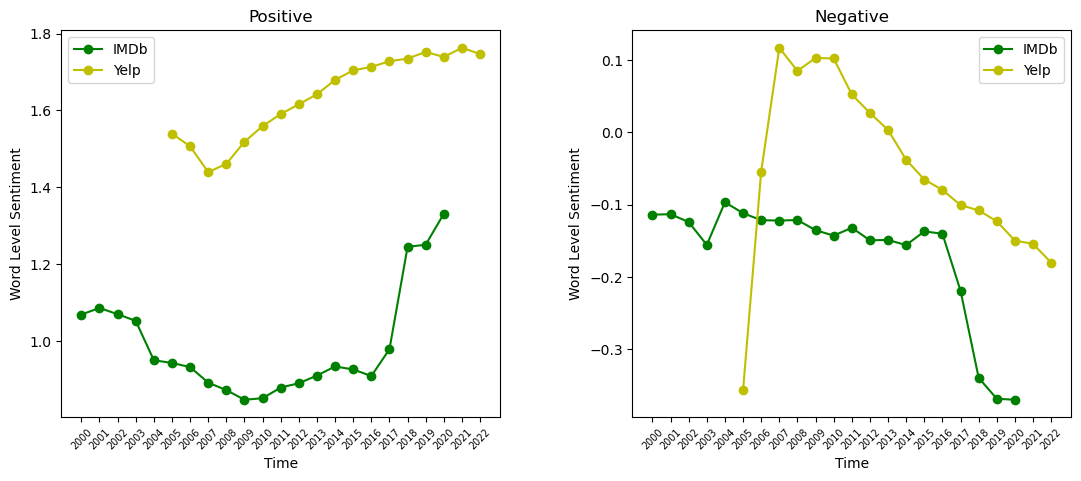

In [31]:
# Generate side by side plots for reviews with positive and negative sentiment for time series of the word-level sentiment metric for the IMDb and Yelp data
get_senti_graph(df_imdb_results, df_yelp_results, 'time', 'rating', 'stars', 'average word level sentiment', 'Word Level Sentiment')

In [26]:
# Initialize empty lists to store IMDb enhanced sentiment data
ls_imdb_average_enhanced_sentiment = []
ls_imdb_std_enhanced_sentiment = []

# Iterate through key-value pairs in the 'df_imdb_split' dictionary
for key, split in df_imdb_split.items():
    # Calculate enhanced sentiment metrics for the current data split
    ls_enhanced_sentiment, average_enhanced_sentiment, std_enhanced_sentiment = get_enhanced_sentiment(split, 'review')

    # Append values to respective lists
    ls_imdb_average_enhanced_sentiment.append(average_enhanced_sentiment)
    ls_imdb_std_enhanced_sentiment.append(std_enhanced_sentiment)

# Add columns for average and standard deviation of enhanced sentiment to the 'df_imdb_results' dataframe
df_imdb_results['average enhanced sentiment'] = ls_imdb_average_enhanced_sentiment
df_imdb_results['std enhanced sentiment'] = ls_imdb_std_enhanced_sentiment

# Save the updated dataframe to a pickle file
#df_imdb_results.to_pickle('imdb_results.pkl')

In [23]:
# Initialize empty lists to store Yelp enhanced sentiment data
ls_yelp_average_enhanced_sentiment = []
ls_yelp_std_enhanced_sentiment = []

# Iterate through key-value pairs in the 'df_yelp_split' dictionary
for key, split in df_yelp_split.items():
    # Calculate enhanced sentiment metrics for the current data split
    ls_enhanced_sentiment, average_enhanced_sentiment, std_enhanced_sentiment = get_enhanced_sentiment(split, 'review')

    # Append values to respective lists
    ls_yelp_average_enhanced_sentiment.append(average_enhanced_sentiment)
    ls_yelp_std_enhanced_sentiment.append(std_enhanced_sentiment)

# Add columns for average and standard deviation of enhanced sentiment to the 'df_yelp_results' dataframe
df_yelp_results['average enhanced sentiment'] = ls_yelp_average_enhanced_sentiment
df_yelp_results['std enhanced sentiment'] = ls_yelp_std_enhanced_sentiment

# Save the updated dataframe to a pickle file
#df_yelp_results.to_pickle('yelp_results.pkl')

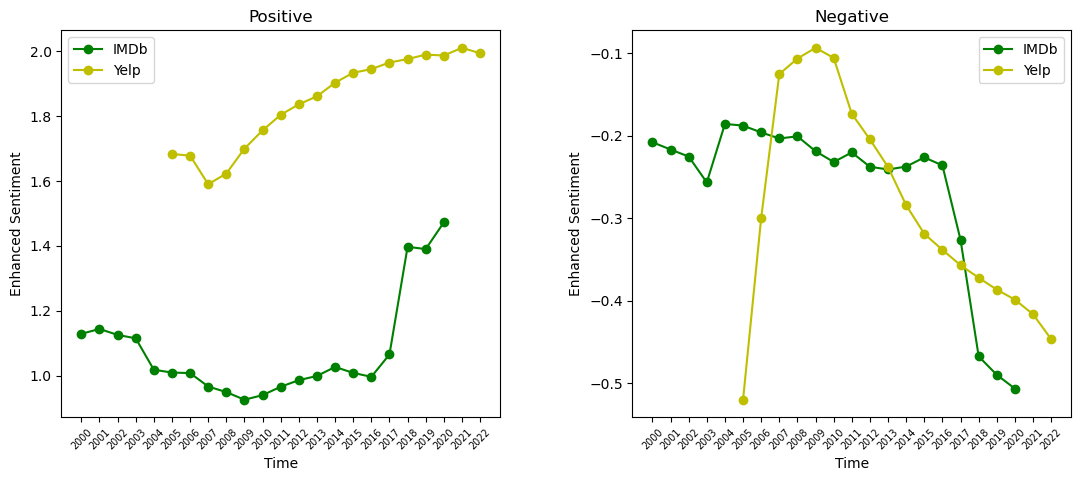

In [64]:
# Generate side by side plots for reviews with positive and negative sentiment for time series of the enhanced sentiment metric for the IMDb and Yelp data
get_senti_graph(df_imdb_results, df_yelp_results, 'time', 'rating', 'stars', 'average enhanced sentiment', 'Enhanced Sentiment')

In [28]:
# Initialize empty lists to store IMDb absolute sentiment data
ls_imdb_average_abs_sentiment = []
ls_imdb_std_abs_sentiment = []

# Iterate through key-value pairs in the 'df_imdb_split' dictionary
for key, split in df_imdb_split.items():
    # Calculate absolute sentiment metrics for the current data split
    ls_abs_sentiment, average_abs_sentiment, std_abs_sentiment = get_word_level_sentiment(split, 'review', lexicon_abs_sentiment)

    # Append values to respective lists
    ls_imdb_average_abs_sentiment.append(average_abs_sentiment)
    ls_imdb_std_abs_sentiment.append(std_abs_sentiment)

# Add columns for average and standard deviation of absolute sentiment to the 'df_imdb_results' dataframe
df_imdb_results['average abs sentiment'] = ls_imdb_average_abs_sentiment
df_imdb_results['std abs sentiment'] = ls_imdb_std_abs_sentiment

# Save the updated datframe to a pickle file
#df_imdb_results.to_pickle('imdb_results.pkl')

In [25]:
# Initialize empty lists to store Yelp absolute sentiment data
ls_yelp_average_abs_sentiment = []
ls_yelp_std_abs_sentiment = []

# Iterate through key-value pairs in the 'df_yelp_split' dictionary
for key, split in df_yelp_split.items():
    # Calculate absolute sentiment metrics for the current data split
    ls_abs_sentiment, average_abs_sentiment, std_abs_sentiment = get_word_level_sentiment(split, 'review', lexicon_abs_sentiment)

    # Append values to respective lists
    ls_yelp_average_abs_sentiment.append(average_abs_sentiment)
    ls_yelp_std_abs_sentiment.append(std_abs_sentiment)

# Add columns for average and standard deviation of absolute sentiment to the 'df_yelp_results' dataframe
df_yelp_results['average abs sentiment'] = ls_yelp_average_abs_sentiment
df_yelp_results['std abs sentiment'] = ls_yelp_std_abs_sentiment

# Save the updated dataframe to a pickle file
#df_yelp_results.to_pickle('yelp_results.pkl')

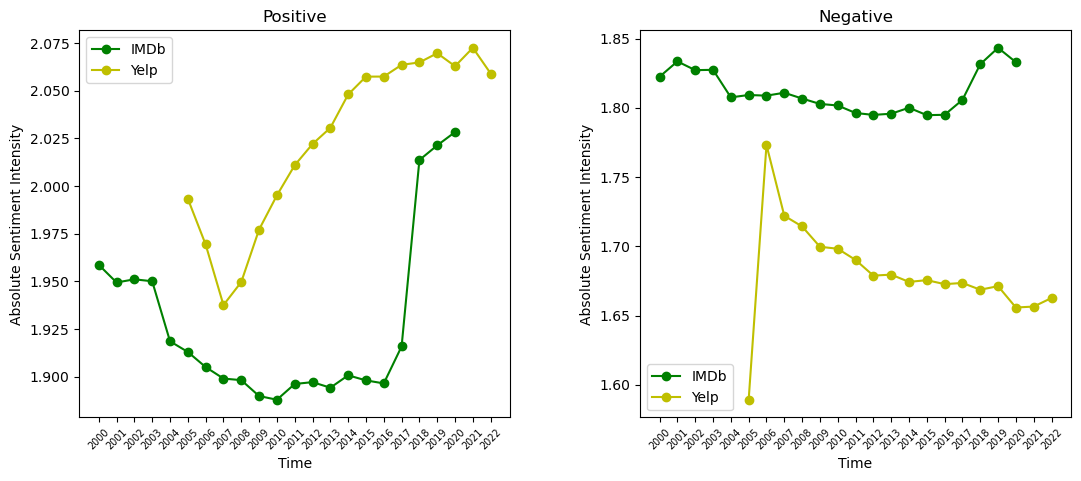

In [65]:
# Generate side by side plots for reviews with positive and negative sentiment for time series of the absolute sentiment metric for the IMDb and Yelp data
get_senti_graph(df_imdb_results, df_yelp_results, 'time', 'rating', 'stars', 'average abs sentiment', 'Absolute Sentiment Intensity')

###### Language Diversity and Comprehensiveness Metrics

In [15]:
# Initialize empty lists to store IMDb lexical diversity data and dictionaries to visualize Zipf's law
ls_imdb_lexical_diversity = []
ls_zipf = []

# Iterate through key-value pairs in the 'df_imdb_split' dictionary
for key, split in df_imdb_split.items():
    # Calculate lexical diversity and get dictionary of frequent words for the current data split
    lexical_diversity, dic_zipf = get_lexical_diversity(split, 'review', lexicon_sentiment)

    # Append values to respective lists
    ls_imdb_lexical_diversity.append(lexical_diversity)
    ls_zipf.append(dic_zipf)

# Add a column for lexical diversity to the 'df_imdb_results' dataframe
df_imdb_results['lexical diversity'] = ls_imdb_lexical_diversity

# Save the updated dataframe to a pickle file
#df_imdb_results.to_pickle('imdb_results.pkl')

In [28]:
# Initialize an empty list to store Yelp lexical diversity data
ls_yelp_lexical_diversity = []

# Iterate through key-value pairs in the 'df_yelp_split' dictionary
for key, split in df_yelp_split.items():
    # Calculate lexical diversity for the current data split
    lexical_diversity, dic_zipf = get_lexical_diversity(split, 'review', lexicon_sentiment)

    # Append lexical diversity values to the list
    ls_yelp_lexical_diversity.append(lexical_diversity)

# Add a column for lexical diversity to the 'df_yelp_results' dataframe
df_yelp_results['lexical diversity'] = ls_yelp_lexical_diversity

# Save the updated DataFrame to a pickle file
#df_yelp_results.to_pickle('yelp_results.pkl')

Text(0, 0.5, 'Frequency')

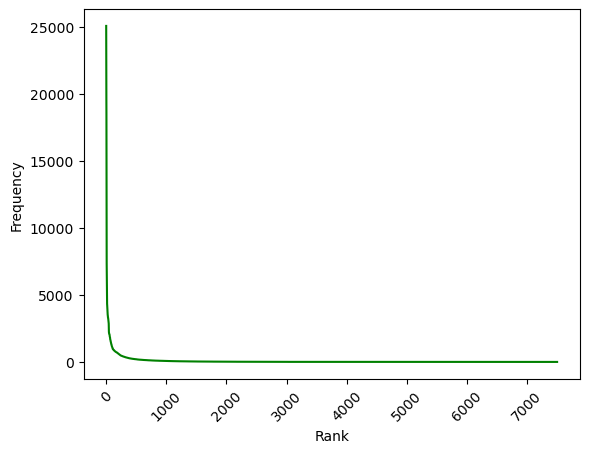

In [66]:
# Example visualization of Zipfian distribution for analysis
# Extract frequency and rank data from a specific dictionary, e.g. negative sentiment in 2002
frequency_negative_2002 = list(ls_zipf[41].values())
rank_negative_2002 = list(range(len(frequency_negative_2002)))

# Plot the Zipfian distribution, means plot frequency against rank
plt.plot(rank_negative_2002, frequency_negative_2002, color='green')

# Rotate x-axis labels for better readability and add labels
plt.xticks(rotation=45)
plt.xlabel('Rank')
plt.ylabel('Frequency')

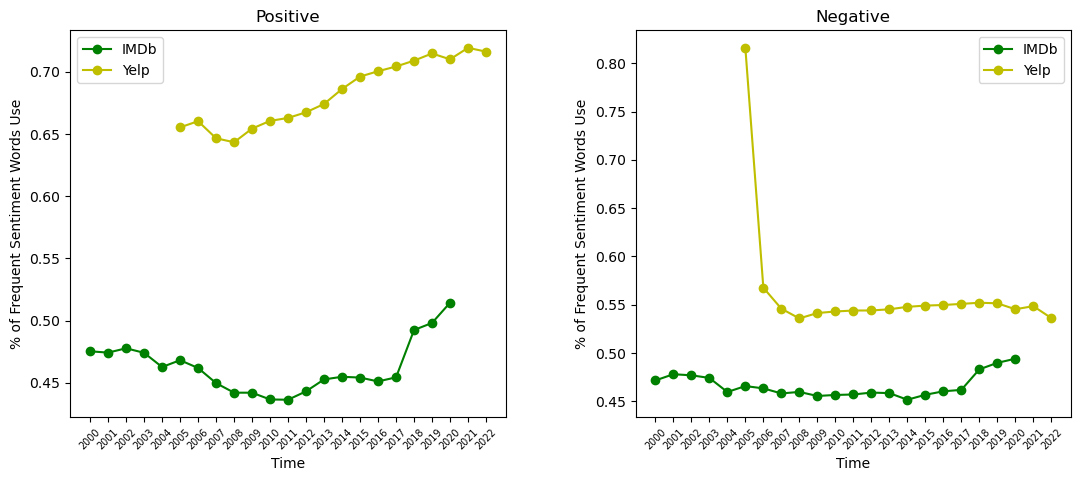

In [67]:
# Generate side by side plots for reviews with positive and negative sentiment for time series of the lexical diversity metric for the IMDb and Yelp data
get_senti_graph(df_imdb_results, df_yelp_results, 'time', 'rating', 'stars', 'lexical diversity', '% of Frequent Sentiment Words Use')

In [32]:
# Initialize empty lists to store IMDb informativeness data
ls_imdb_average_informativeness = []
ls_imdb_std_informativeness = []

# Iterate through key-value pairs in the 'df_imdb_split' dictionary
for key, split in df_imdb_split.items():
    # Calculate informativeness metrics for the current data split
    average_informativeness, std_informativeness = get_informativeness(split, 'review')

    # Append values to respective lists
    ls_imdb_average_informativeness.append(average_informativeness)
    ls_imdb_std_informativeness.append(std_informativeness)

# Add columns for average and standard deviation of informativeness to the 'df_imdb_results' dataframe
df_imdb_results['average informativeness'] = ls_imdb_average_informativeness
df_imdb_results['std informativeness'] = ls_imdb_std_informativeness

# Save the updated dataframe to a pickle file
#df_imdb_results.to_pickle('imdb_results.pkl')

In [30]:
# Initialize empty lists to store Yelp informativeness data
ls_yelp_average_informativeness = []
ls_yelp_std_informativeness = []

# Iterate through key-value pairs in the 'df_yelp_split' dictionary
for key, split in df_yelp_split.items():
    # Calculate informativeness metrics for the current data split
    average_informativeness, std_informativeness = get_informativeness(split, 'review')

    # Append values to respective lists
    ls_yelp_average_informativeness.append(average_informativeness)
    ls_yelp_std_informativeness.append(std_informativeness)

# Add columns for average and standard deviation of informativeness to the 'df_yelp_results' dataframe
df_yelp_results['average informativeness'] = ls_yelp_average_informativeness
df_yelp_results['std informativeness'] = ls_yelp_std_informativeness

# Save the updated dataframe to a pickle file
#df_yelp_results.to_pickle('yelp_results.pkl')

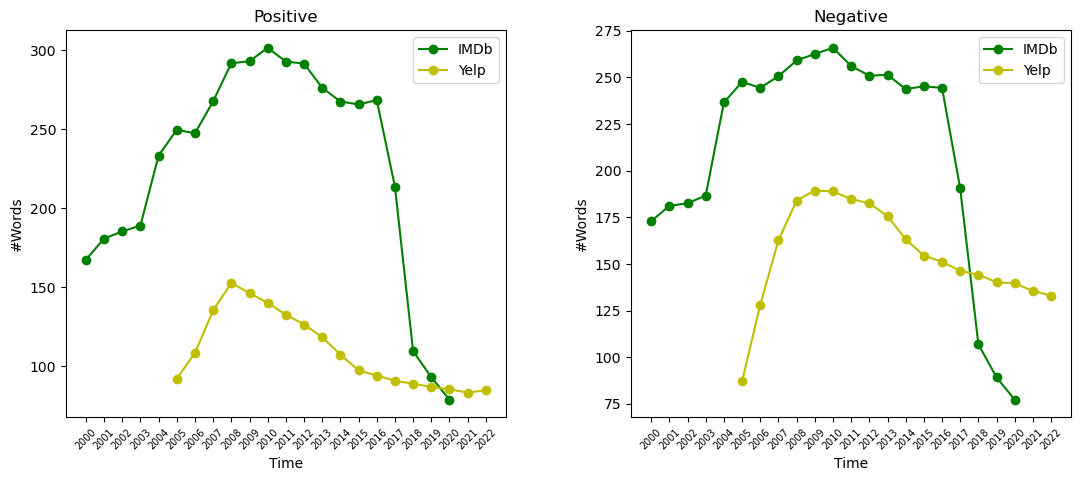

In [68]:
# Generate side by side plots for reviews with positive and negative sentiment for time series of the informativeness metric for the IMDb and Yelp data
get_senti_graph(df_imdb_results, df_yelp_results, 'time', 'rating', 'stars', 'average informativeness', '#Words')

In [28]:
# Initialize an empty list to store IMDb dichotomy data
ls_imdb_dichotomy = []  # List to store dichotomy values

# Iterate through key-value pairs in the 'df_imdb_split' dictionary
for key, split in df_imdb_split.items():
    # Calculate the dichotomy metric for the current data split
    dichotomy = get_dichotomy(split, 'review', 'rating', 1.0)

    # Append the dichotomy value to the list
    ls_imdb_dichotomy.append(dichotomy)

# Add a column for the dichotomy metric to the 'df_imdb_results' dataframe
df_imdb_results['dichotomy'] = ls_imdb_dichotomy

# Save the updated DataFrame to a pickle file
#df_imdb_results.to_pickle('imdb_results.pkl')

In [29]:
# Initialize an empty list to store Yelp dichotomy data
ls_yelp_dichotomy = []  # List to store dichotomy values

# Iterate through key-value pairs in the 'df_yelp_split' dictionary
for key, split in df_yelp_split.items():
    # Calculate the dichotomy metric for the current data split
    dichotomy = get_dichotomy(split, 'review', 'stars', 1.0)

    # Append the dichotomy value to the list
    ls_yelp_dichotomy.append(dichotomy)

# Add a column for the dichotomy metric to the 'df_yelp_results' dataframe
df_yelp_results['dichotomy'] = ls_yelp_dichotomy

# Save the updated DataFrame to a pickle file
#df_yelp_results.to_pickle('yelp_results.pkl')

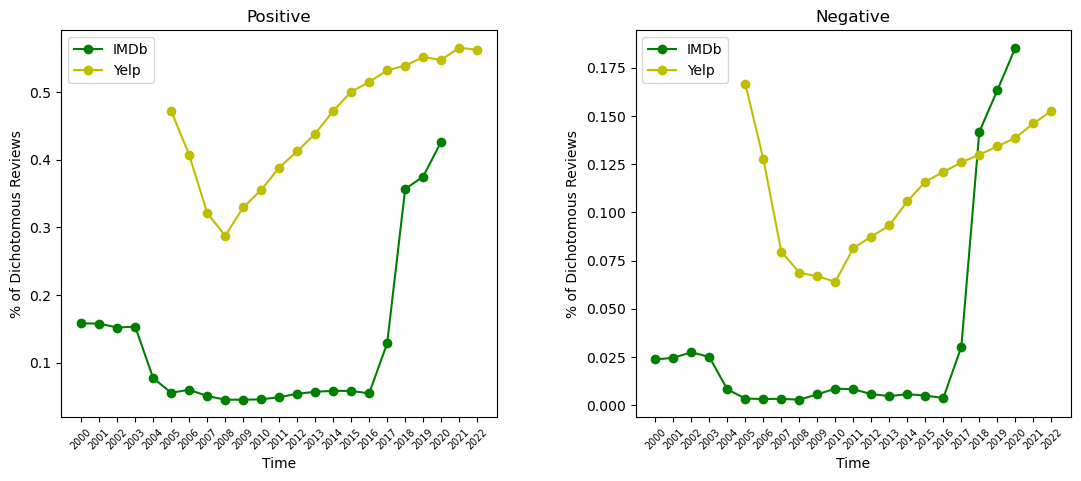

In [32]:
# Generate side by side plots for reviews with positive and negative sentiment for time series of the dichotomy aka review one-sidedness metric for the IMDb and Yelp data
get_senti_graph(df_imdb_results, df_yelp_results, 'time', 'rating', 'stars', 'dichotomy', '% of Dichotomous Reviews')

###### Intense Reviews

In [76]:
# Initialize an empty list to store for the IMDb data intense reviews
ls_imdb_nested_3_intense_reviews = []

# Iterate through key-value pairs in the 'df_imdb_split' dictionary
for key, split in df_imdb_split.items():
    time, rating = key

    # Determine if the rating is minimum (1.0) to identify if we have a sample of reviews with negative sentiment, hence intense terms are sentiment words with a score smaller -3
    min = rating == 1.0

    # Calculate and collect list of 3 intense reviews for the current data split
    ls_3_intense_reviews = get_n_intense_reviews(split, 3, 'review', min, lexicon_sentiment)

    # Append the nested list to the main list
    ls_imdb_nested_3_intense_reviews.append(ls_3_intense_reviews)

# Save the collected data to a pickle file
#with open("imdb_3_intense_reviews.pkl", "wb") as file:
#    pickle.dump(ls_imdb_nested_3_intense_reviews, file)

In [35]:
# Select data of interest in creating a latex-style table
data = [
    (df_imdb_results.iloc[0, 0], df_imdb_results.iloc[0, 1], ls_imdb_nested_3_intense_reviews[0][0]),
    (df_imdb_results.iloc[1, 0], df_imdb_results.iloc[1, 1], ls_imdb_nested_3_intense_reviews[1][0]),
    (df_imdb_results.iloc[-2, 0], df_imdb_results.iloc[-2, 1], ls_imdb_nested_3_intense_reviews[-2][0]),
    (df_imdb_results.iloc[-1, 0], df_imdb_results.iloc[-1, 1], ls_imdb_nested_3_intense_reviews[-1][0]),
]

# Convert data into a list of lists for creating a table
table = []
for year, sent, review in data:
    sent_label = 'neg' if sent == 1.0 else 'pos'
    table.append([year, sent_label, review])

# Add a header row for the table
headers = ['Year', 'Sent', 'Review']
table.insert(0, headers)

# Define a subtitle for the table
subtitle = "A selection of IMDb reviews with year, sentiment, and review content."

# Construct the complete LaTeX table code with title, subtitle, and column headers
table_latex = f"""
\\begin{{table}}[ht]
\\centering
\\begin{{tabular}}{{c|c|p{{6cm}}}}
\\hline
{headers[0]} & {headers[1]} & {headers[2]} \\\\
\\hline
"""

# Add data rows to the LaTeX table code
for row in table[1:]:
    table_latex += f"{row[0]} & {row[1]} & {row[2]} \\\\"
table_latex += f"\\hline\\end{{tabular}}\n\\caption{{{subtitle}}}\n\\end{{table}}"

# Printing the table to access the code for some latex editor
print(table_latex)


\begin{table}[ht]
\centering
\begin{tabular}{c|c|p{6cm}}
\hline
Year & Sent & Review \\
\hline
2000 & neg & One of the worst ever. But it was a good laugh. I would recommend seeing this if you were drunk on something, or if you are a masochist. Real bad. \\2000 & pos & Great story and great action! Needless to say anything beyond this!! \\2020 & neg & Not good story is worst acting is worst. \\2020 & pos & The best. \\\hline\end{tabular}
\caption{A selection of IMDb reviews with year, sentiment, and review content.}
\end{table}


In [78]:
# Initialize an empty list to store for the Yelp data intense reviews
ls_yelp_nested_3_intense_reviews = []

# Iterate through key-value pairs in the 'df_imdb_split' dictionary
for key, split in df_yelp_split.items():
    time, rating = key

    # Determine if the rating is minimum (1.0) to identify if we have a sample of reviews with negative sentiment, hence intense terms are sentiment words with a score smaller -3
    min = rating == 1.0

     # Calculate and collect list of 3 intense reviews for the current data split
    ls_3_intense_reviews = get_n_intense_reviews(split, 3, 'review', min, lexicon_sentiment)

    # Append the nested list to the main list
    ls_yelp_nested_3_intense_reviews.append(ls_3_intense_reviews)

# Save the collected data to a pickle file
#with open("yelp_3_intense_reviews.pkl", "wb") as file:
#    pickle.dump(ls_yelp_nested_3_intense_reviews, file)

In [37]:
# Select data of interest in creating a latex-style table
data = [
    (df_yelp_results.iloc[0, 0], df_yelp_results.iloc[0, 1], ls_yelp_nested_3_intense_reviews[0][0]),
    (df_yelp_results.iloc[1, 0], df_yelp_results.iloc[1, 1], ls_yelp_nested_3_intense_reviews[1][0]),
    (df_yelp_results.iloc[-2, 0], df_yelp_results.iloc[-2, 1], ls_yelp_nested_3_intense_reviews[-2][0]),
    (df_yelp_results.iloc[-1, 0], df_yelp_results.iloc[-1, 1], ls_yelp_nested_3_intense_reviews[-1][0]),
]

# Convert data into a list of lists for creating a table
table = []
for year, sent, review in data:
    sent_label = 'neg' if sent == 1.0 else 'pos'
    table.append([year, sent_label, review])

# Add a header row for the table
headers = ['Year', 'Sent', 'Review']
table.insert(0, headers)

# Define a subtitle for the table
subtitle = "A selection of Yelp reviews with year, sentiment, and review content."

# Construct the complete LaTeX table code with title, subtitle, and column headers
table_latex = f"""
\\begin{{table}}[ht]
\\centering
\\begin{{tabular}}{{c|c|p{{6cm}}}}
\\hline
{headers[0]} & {headers[1]} & {headers[2]} \\\\
\\hline
"""

# Add data rows to the LaTeX table code
for row in table[1:]:
    table_latex += f"{row[0]} & {row[1]} & {row[2]} \\\\"
table_latex += f"\\hline\\end{{tabular}}\n\\caption{{{subtitle}}}\n\\end{{table}}"

# Printing the table to access the code for some latex editor
print(table_latex)


\begin{table}[ht]
\centering
\begin{tabular}{c|c|p{6cm}}
\hline
Year & Sent & Review \\
\hline
2005 & neg & eww.. Starbucks.  If you have any taste, you will not be caught dead in the green monster while in New Orleans.  This one is super tiny, and four blocks to Cafe Du Monde.  Go for it.  There's also coffee on the third floor of Virgin, two blocks away. \\2005 & pos & The best wet n sloppy BBQ around.  Try the sweet potato pie too. \\2022 & neg & Owner is a drunken racist. DJ was thrown out because too many "n*****s" were there. \\2022 & pos & this had great food would recommend \\\hline\end{tabular}
\caption{A selection of Yelp reviews with year, sentiment, and review content.}
\end{table}


###### Statistical Significance Analysis

In [3]:
# Define a list of time series metrics for statistical analysis
ls_time_series = ['average word level sentiment', 'average enhanced sentiment', 'average abs sentiment', 'lexical diversity', 'average informativeness', 'dichotomy']

In [ ]:
# Calculate controlled Mann-Kendall p-values for IMDb data
ls_imdb_pvals = controlled_mannkendall(df_imdb_results, ls_time_series, 'rating')

# Calculate controlled Mann-Kendall p-values for the last ten years of IMDb data
cutoff = df_imdb_results.index[df_imdb_results['time'] == 2010].tolist()
ls_imdb_pvals_last_decade = controlled_mannkendall(df_imdb_results.iloc[cutoff[0]:, ], ls_time_series, 'rating')

# Save the calculated p-values to pickle files
# with open("imdb_pvalues.pkl", "wb") as file:
#     pickle.dump(ls_imdb_pvals, file)

# with open("imdb_pvalues_decade.pkl", "wb") as file:
#     pickle.dump(ls_imdb_pvals_last_decade, file)

In [38]:
# Print results of rejecting the H0 for all time series of the IMDb data set
print(f'For each of the metrics for the IMDb data, can the hypothesis of no trend be rejected?')
for i in range(len(ls_imdb_pvals[0])):
    print(f'H{i+1}: {ls_imdb_pvals[0][i]} with p-value {ls_imdb_pvals[1][i]}')
print('-----------------------------------------------------------------')

# Print results of rejecting the H0 for the time series reduced to the last 10 years of the IMDb data set
print(f'For each of the metrics for the IMDb data of the last ten years, can the hypothesis of no trend be rejected?')
for i in range(len(ls_imdb_pvals_last_decade[0])):
    print(f'H{i+1}: {ls_imdb_pvals_last_decade[0][i]} with p-value {ls_imdb_pvals_last_decade[1][i]}')

For each of the metrics for the IMDb data, can the hypothesis of no trend be rejected?
H1: True with p-value 0.00100555191095446
H2: False with p-value 1.0
H3: True with p-value 0.0023378281545588923
H4: False with p-value 1.0
H5: False with p-value 1.0
H6: False with p-value 1.0
H7: False with p-value 1.0
H8: False with p-value 1.0
H9: False with p-value 1.0
H10: False with p-value 1.0
H11: False with p-value 1.0
H12: False with p-value 1.0
-----------------------------------------------------------------
For each of the metrics for the IMDb data of the last ten years, can the hypothesis of no trend be rejected?
H1: True with p-value 0.030250432729736446
H2: True with p-value 0.0031853559399941936
H3: True with p-value 0.030250432729736446
H4: True with p-value 0.00457218651631296
H5: False with p-value 0.2937380946147219
H6: True with p-value 0.005727460460401894
H7: True with p-value 0.014399437456344373
H8: True with p-value 0.005727460460401894
H9: True with p-value 0.003185355939

In [10]:
# Calculate controlled Mann-Kendall p-values for Yelp data
ls_yelp_pvals = controlled_mannkendall(df_yelp_results, ls_time_series, 'stars')

# Calculate controlled Mann-Kendall p-values for the last ten years of Yelp data
cutoff = df_yelp_results.index[df_yelp_results['time'] == 2012].tolist()
ls_yelp_pvals_last_decade = controlled_mannkendall(df_yelp_results.iloc[cutoff[0]:, ], ls_time_series, 'stars')

# Save the calculated p-values to pickle files
#with open("yelp_pvalues.pkl", "wb") as file:
#    pickle.dump(ls_yelp_pvals, file)

#with open("yelp_pvalues_decade.pkl", "wb") as file:
#    pickle.dump(ls_yelp_pvals_last_decade, file)

In [39]:
# Print results of rejecting the H0 for all time series of the Yelp data set
print(f'For each of the metrics for the yelp data can the hypothesis of no trend be rejected?')
for i in range(len(ls_yelp_pvals[0])):
    print(f'H{i+1}: {ls_yelp_pvals[0][i]} with p-value {ls_yelp_pvals[1][i]}')
print('-----------------------------------------------------------------')

# Print results of rejecting the H0 for the time series reduced to the last 10 years of the Yelp data set
print(f'For each of the metrics for the yelp data of the last ten years can the hypothesis of no trend be rejected?')
for i in range(len(ls_yelp_pvals_last_decade[0])):
    print(f'H{i+1}: {ls_yelp_pvals_last_decade[0][i]} with p-value {ls_yelp_pvals_last_decade[1][i]}')

For each of the metrics for the yelp data can the hypothesis of no trend be rejected?
H1: True with p-value 0.000957104871917211
H2: True with p-value 4.79447172641563e-06
H3: True with p-value 0.00203818809156858
H4: True with p-value 4.79447172641563e-06
H5: True with p-value 0.0004347661937603214
H6: True with p-value 2.459826613207219e-05
H7: False with p-value 1.0
H8: True with p-value 4.79447172641563e-06
H9: True with p-value 0.042051931990344356
H10: True with p-value 0.0002668159886201049
H11: True with p-value 0.005451713289479939
H12: True with p-value 4.085124932375427e-05
-----------------------------------------------------------------
For each of the metrics for the yelp data of the last ten years can the hypothesis of no trend be rejected?
H1: True with p-value 0.000244248896869035
H2: True with p-value 0.0007711718755436828
H3: True with p-value 0.000244248896869035
H4: True with p-value 0.000461844604642352
H5: True with p-value 0.006873194522491625
H6: True with p-va